### Chest X-ray images 

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

<br>
<hr>


In [1]:
!pip install mlxtend

In [79]:
import os 
import glob 
import time 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import InputLayer, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPool2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


# further packages
from mlxtend.plotting import plot_confusion_matrix

In [2]:
# set seed 
seed = 42 
np.random.seed(seed)
tf.random.set_seed(seed=seed)

In [3]:
# GPU check 
if tf.test.gpu_device_name():
    print('Default GPU device: {}'.format(tf.test.gpu_device_name()))
else: 
    print('Please install GPU for tensorflow')

Please install GPU for tensorflow


In [35]:
# loading images dataset 

dir_train = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/train"
dir_test = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/test"
dir_valid = "/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val"



train_dataset = image_dataset_from_directory(directory=dir_train,
                                             labels='inferred',
                                             class_names=["NORMAL", "PNEUMONIA"],
                                             image_size=(224, 224),
                                             batch_size=32)


test_dataset = image_dataset_from_directory(directory=dir_test,
                                            labels='inferred',
                                            class_names=["NORMAL", "PNEUMONIA"],
                                            image_size=(224, 224),
                                            batch_size=32)




valid_dataset = image_dataset_from_directory(directory=dir_valid,
                                            labels='inferred',
                                            class_names=["NORMAL", "PNEUMONIA"],
                                            image_size=(224, 224),
                                            batch_size=32)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


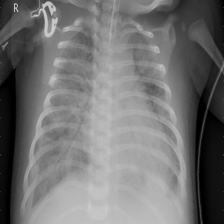

In [6]:
# image size 
img = load_img("/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
img.resize((224, 224))

In [7]:
# class labels 
class_names = train_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


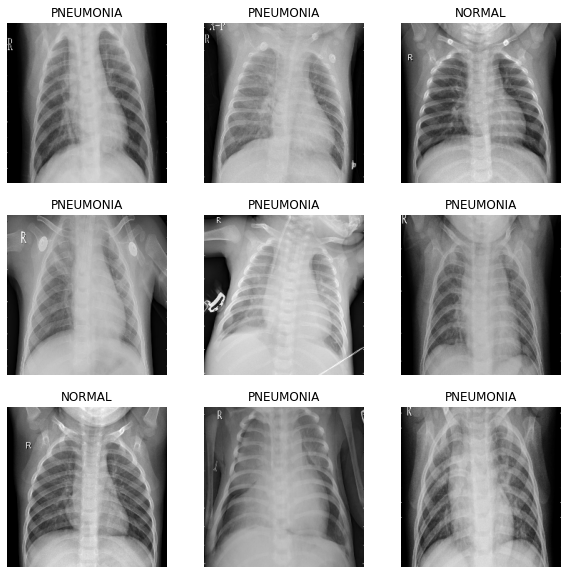

In [ ]:
# image samples

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


<br>
<hr>
<br>
<br>

### ResNet50  

<br>

In [ ]:
# preprocessing images 

%%time
for image_batch, labels_batch in tqdm(train_dataset, desc="Preprocessing images "):
  preprocess_input(image_batch)

Preprocessing images : 100%|██████████| 163/163 [21:42<00:00,  7.99s/it]

CPU times: user 35.3 s, sys: 2.53 s, total: 37.8 s
Wall time: 21min 42s


In [ ]:
# Resnet
resnet = ResNet50(include_top=False, input_shape=[224, 224, 3], weights='imagenet', classes=2)

In [ ]:
# set up layers 
for layers in resnet.layers[:50]:
    layers.trainable=False

In [ ]:
# last layer 
resnet.layers[174]

In [ ]:
# Resnet50 with fine-tuning 

#image = resnet.input
#image = preprocess_input(image)
input = resnet.output
x = Flatten()(input)
output_layer = Dense(1, activation="sigmoid")(x)


model = Model(inputs=resnet.input, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# config network 
model.compile(optimizer=Adam(lr=0.001),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


# callbacks 
early_stopper = EarlyStopping(patience=10)
learning_rate_reduction= ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

In [ ]:
%%time 

history = model.fit(train_dataset,  # normalized images
          epochs=30,
          validation_data=test_dataset,
          callbacks=[early_stopper, learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 94s 564ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.8872 - val_accuracy: 0.7356
Epoch 2/20
163/163 [==============================] - 93s 556ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 2.7971 - val_accuracy: 0.7468
Epoch 3/20
163/163 [==============================] - 93s 562ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.1136 - val_accuracy: 0.7388
Epoch 4/20
163/163 [==============================] - 93s 560ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 3.2605 - val_accuracy: 0.7404

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 5/20
163/163 [==============================] - 94s 564ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.1026 - val_accuracy: 0.7500
Epoch 6/20
163/163 [==============================] - 94s 563ms/step - loss: 9.6796e-04 - accuracy: 1.0000 - val_loss: 3.1502 - val_accuracy: 0.7548
Epoch 7/20
163/163 [==============================] - 91s 54

In [ ]:
loss, accuracy = model.evaluate(valid_dataset)

1/1 [==============================] - 8s 8s/step - loss: 0.1744 - accuracy: 0.9375


In [ ]:
# save model 
!mkdir -p /content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model
model.save('/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model/resnet_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model/resnet_model/assets


In [ ]:
!ls /content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model

resnet_model


<br>
<hr>
<br>
<br>

### Evaluate model
<br>

In [5]:
# load model 

new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/saved_model/resnet_model')

In [6]:
new_model.evaluate(valid_dataset)

1/1 [==============================] - 4s 4s/step - loss: 0.1744 - accuracy: 0.9375


[0.1744164377450943, 0.9375]

NameError: ignored

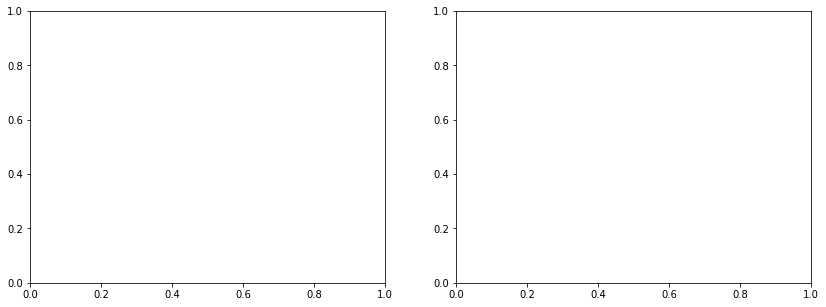

In [11]:
epochs = [i for i in range(0,12)]

fig, ax = plt.subplots(1,2, figsize=(14,5))


# Loss 
ax[0].plot(epochs, history.history['loss'], label='train loss')
ax[0].plot(epochs, history.history['val_loss'], label='test loss')
ax[0].set_xlabel('Epochs', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].set_title('Loss CNN', fontsize=14)
ax[0].legend()


# Accuracy 
ax[1].plot(epochs, history.history['accuracy'], label='train accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='test accuracy')
ax[1].set_xlabel('Epochs', fontsize=13)
ax[1].set_ylabel('Loss', fontsize=13)
ax[1].set_title('Accuracy CNN', fontsize=14)
ax[1].legend()

plt.show()

In [36]:
y_true = []

for image, label in valid_dataset.take(1):
    y_true.append(label)

In [37]:
y_true = np.array(y_true)

In [38]:
y_pred = new_model.predict(valid_dataset)
y_pred = np.around(y_pred, decimals=0)

In [39]:
y_true = y_true.reshape(-1, 1)

In [40]:
y_true.shape, y_pred.shape

((16, 1), (16, 1))

In [69]:
print(classification_report(y_true, y_pred, target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.57      0.50      0.53         8
   Pneumonia       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16



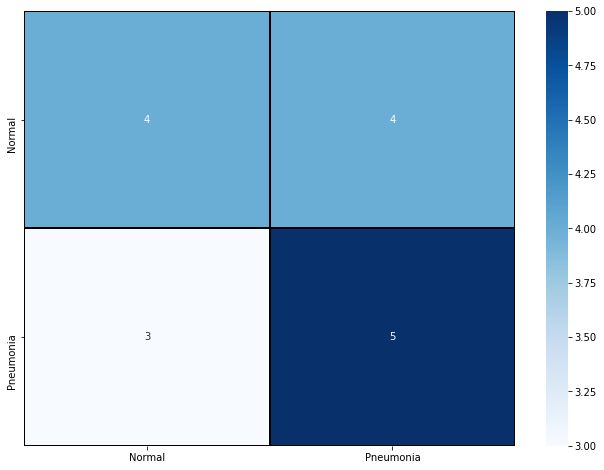

In [77]:
# confusion matrix 


labels = ["Normal", "Pneumonia"]

cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (11,8))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1 , annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.show()

In [68]:
print(accuracy_score(y_true, y_pred))

0.5625


<br>
<hr>
<br>
<br>


### Inference 


<br>

In [63]:
def inference(image_path):

    # preprocessing image 
    img_path = image_path
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # prediction 
    y_pred = new_model.predict(x)
    y_pred = np.around(y_pred, decimals=0)

    if y_pred==1:
      print("Pneumonia")
    else: 
      print("Normal")

In [83]:
# inference (pneumonia)
inference(image_path='/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/PNEUMONIA/person1947_bacteria_4876.jpeg')

Pneumonia


In [82]:
# inference (normal)
inference(image_path='/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/NORMAL/NORMAL2-IM-1430-0001.jpeg')

Normal


In [61]:
# Pneumonia image 

img_path = '/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/PNEUMONIA/person1947_bacteria_4876.jpeg'
img = load_img(img_path, target_size=(224, 224))
pneumonia = img_to_array(img)
pneumonia = np.expand_dims(pneumonia, axis=0)
pneumonia = preprocess_input(pneumonia)

In [62]:
# Normal image 

img_path = '/content/drive/MyDrive/Deep_Learning_Projetos/pneumonia_case/images/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'
img = load_img(img_path, target_size=(224, 224))
normal = img_to_array(img)
normal = np.expand_dims(normal, axis=0)
normal = preprocess_input(normal)

In [59]:
y_inference = new_model.predict(x)
y_inference = np.around(y_inference, decimals=0)

y_inference.shape

(1, 1)

In [60]:
if y_inference==1:
  print("Pneumonia")
else: 
  print("Normal")

Normal


<br>
<hr>
<br>
<br>


### GradCAM interpretability 

Implementation of GradCAM method for Convolutional neural networks

<br>